In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from my_functions import *

In [2]:
houses_train_cleaned = pd.read_csv('../datasets/cleaned/house_train_cleaned.csv')
houses_test_cleaned = pd.read_csv('../datasets/cleaned/house_test_cleaned.csv')

In [3]:
# # mean_corr = houses_train_cleaned.corr()['SalePrice'].mean()
features = get_features(houses_train_cleaned, 3)
len(features)


106

In [4]:
X_real_test = houses_test_cleaned[[col for col in features if col in houses_test_cleaned]]
X_real_test.shape

(878, 104)

## Prepping model for Kaggle Submission

In [5]:
# Garage Cars was type int64 in houses_test_cleaned, was type float in houses_train_cleaned_pol_scale
houses_test_cleaned['Garage Cars'] = houses_test_cleaned['Garage Cars'].apply(lambda x: float(x))

In [6]:
houses_test_cleaned.shape

(878, 287)

## Testing!!

### Splitting the Data

In [7]:
outlier_indices = [1796, 125]
X = houses_train_cleaned[[col for col in features if col in houses_test_cleaned]].drop(outlier_indices)
y = houses_train_cleaned['SalePrice'].drop(outlier_indices)

In [8]:
model = sm.OLS(y, X).fit()

In [9]:
significant_features = list(model.pvalues[model.pvalues < 0.02].index) # Thanks foxyblue from Stack Overflow! https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas/41212509

In [10]:
X = houses_train_cleaned[[col for col in significant_features if col in houses_test_cleaned]].drop(outlier_indices) # Dropping columns not in houses_test_cleaned

In [11]:
X_train, X_test, y_train, y_test = get_cval_r2score_rmse(X, y)

The Cross Validation Score is: [0.92844733 0.91175806 0.93742077 0.92143703 0.92209579 0.90564168
 0.9174575  0.93553792 0.92980107 0.90073674]
The R2 score on testing data is: 0.9318458102896436
The RMSE is 20363.639129780924


In [12]:
# Baseline Model
null_pred = np.zeros_like(y_test)
null_pred = null_pred + y_test.mean()
print(f'The Baseline RMSE is {metrics.mean_squared_error(y_test, null_pred, squared=False)}')

The Baseline RMSE is 78002.60607671052


## The Model is drastically outperforming the Baseline!

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
y_pred = lr.predict(X_test)

In [15]:
resids = y_test - y_pred

Text(0.5, 1.0, 'Plot of residuals')

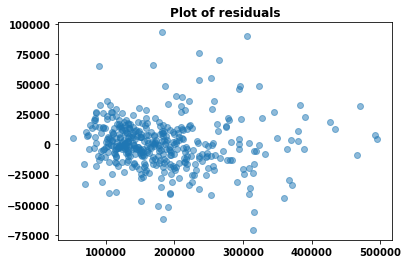

In [16]:
plt.scatter(y_pred, resids, alpha=0.5)
plt.title('Plot of residuals')

The Residuals seem pretty consistent when homes are under ~220k, but the model doesn't do a great job of generalizing the prices of homes above 220k.

In [17]:
X.shape

(2046, 42)

## Training model on all data

In [18]:
lr.fit(X, y)

LinearRegression()

In [19]:
X_real_test = houses_test_cleaned[[col for col in significant_features if col in houses_test_cleaned]]
X_real_test.shape

(878, 42)

In [20]:
houses_test_cleaned['SalePrice'] = lr.predict(X_real_test)

submission = houses_test_cleaned[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,180695.940004
std,850.838263,77545.624605
min,2.000000,40762.587522
25%,692.250000,127834.864787
50%,1433.000000,161299.878150
75%,2197.500000,212961.605187
max,2928.000000,677187.825165


In [21]:
submission.to_csv('../submissions/test56_linreg.csv', index=False)